《[利用Python进行数据分析](https://book.douban.com/subject/25779298/)》读书笔记。
 
 [第10章](/2017/07/20/python_data_analysis10.html)  第8节：移动窗口函数

所有用到的数据可以从[作者的 github](https://github.com/wesm/pydata-book)下载。


In [1]:
%pylab inline
import pandas as pd
from datetime import datetime
from pandas import Series, DataFrame

Populating the interactive namespace from numpy and matplotlib


在移动窗口（可以带有指数衰减权数）上计算的各种统计函数也是一类常见于时间序列的数组变换。

称为移动窗口函数（moving window function），其中还包括那些窗口不定长的函数（如指数加权移动平均）。

跟其他统计函数一样，移动窗口函数也会自动排除缺失值。这样的函数通常需要指定一些数量的非NA观测值。

In [3]:
close_px_all = pd.read_csv('data/ch09/stock_px.csv', parse_dates=True, index_col=0)
close_px = close_px_all[['AAPL', 'MSFT', 'XOM']]
close_px = close_px.resample('B').ffill()
close_px.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2292 entries, 2003-01-02 to 2011-10-14
Freq: B
Data columns (total 3 columns):
AAPL    2292 non-null float64
MSFT    2292 non-null float64
XOM     2292 non-null float64
dtypes: float64(3)
memory usage: 71.6 KB


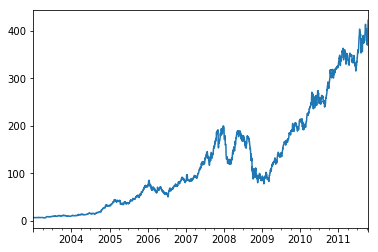

In [8]:
# rolling_mean是其中最简单的一个。它接受一个TimeSeries或DataFrame以及一个window（表示期数）
close_px = close_px.asfreq('B').fillna(method='ffill')


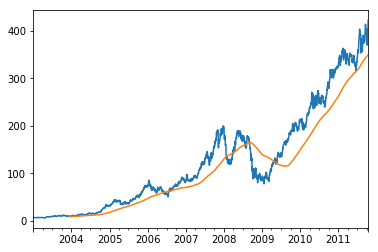

In [19]:
close_px.AAPL.plot()
# pd.rolling_mean is deprecated
#pd.rolling_mean(close_px.AAPL, 250).plot()
# 250均线
close_px.AAPL.rolling(window=250,center=False).mean().plot()

In [18]:
# 两个 figure
plt.figure()

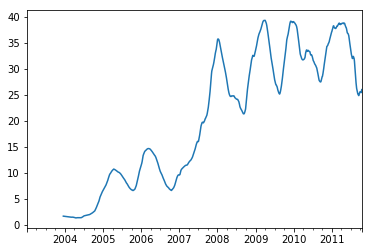

In [26]:
#close_px.AAPL.plot()
# 250期的标准差
close_px.AAPL.rolling(window=250,center=False).std().plot()

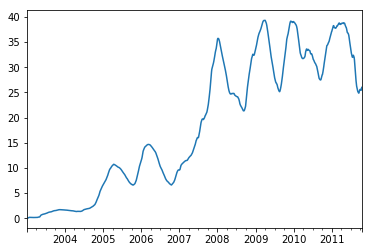

In [28]:
# 计算前面所有数的std，比如min_periods = 10时，计算前10个数的，
# min_periods = 20时，计算前20个数的，直到min_periods = 250为止，
# 这就是所谓的“指定的非NA观测值”
close_px.AAPL.rolling(window=250,min_periods = 10).std().plot()

要计算扩展窗口平均（expanding window mean），可以将扩展窗口看作一个特殊的窗口，

其长度与时间序列一样，但只需一期或多期即可计算一个值。

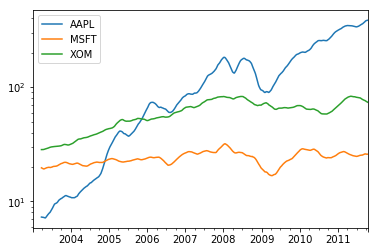

In [30]:
# Define expanding mean in terms of rolling_mean
expanding_mean = lambda x: rolling_mean(x, len(x), min_periods=1)
close_px.rolling(window=60,center=False).mean().plot(logy=True)

In [31]:
plt.close('all')

pandas中的移动窗口和指数加权函数：

![移动窗口和指数加权函数](moving_window_functions.png)

## 指数加权函数

另一种使用固定大小窗口及相等权数观测值的方法是，

定义一个衰减因子（decay factor）常量，以便使近期的观测值拥有更大的权数。

衰减因子的定义方式有很多，比较流行的是使用时间间隔（span），

它可以使结果兼容于窗口大小等于时间间隔的简单移动窗口函数。

由于指数加权统计赋予近期的观测值更大的权重，因此更能适应较快的变化。

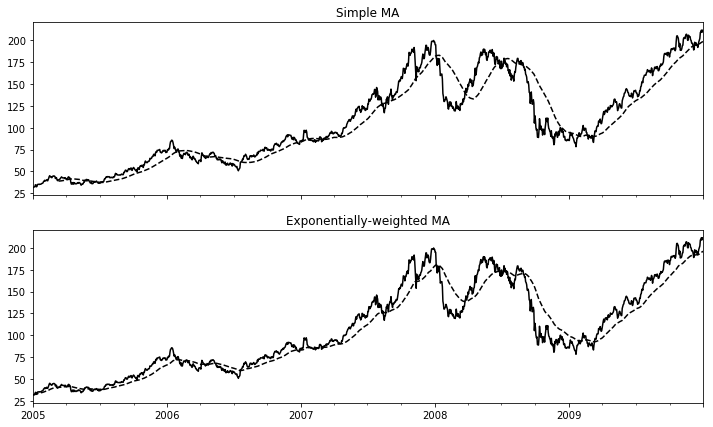

In [33]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True,
                         figsize=(12, 7))

aapl_px = close_px.AAPL['2005':'2009']

ma60 = aapl_px.rolling(window=60,min_periods=50,center=False).mean()
ewma60 = aapl_px.ewm(span=60,min_periods=0,adjust=True,ignore_na=False).mean()

aapl_px.plot(style='k-', ax=axes[0])
ma60.plot(style='k--', ax=axes[0])
aapl_px.plot(style='k-', ax=axes[1])
ewma60.plot(style='k--', ax=axes[1])
axes[0].set_title('Simple MA')
axes[1].set_title('Exponentially-weighted MA')

## 二元移动窗口函数

有些统计运算（如相关系数和协方差）需要在两个时间序列上执行。

比如，金融分析师常常对某只股票对某个参数（如标普500指数）的相关系数感兴趣。

我们可以通过计算百分比变化并使用rolling_corr的方式得到该结果。

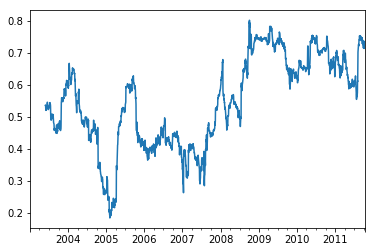

In [36]:
spx_px = close_px_all['SPX']
spx_rets = spx_px / spx_px.shift(1) - 1
returns = close_px.pct_change()
corr = returns.AAPL.rolling(window=125,min_periods=100).corr(other=spx_rets)
corr.plot()

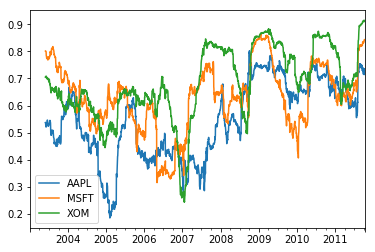

In [38]:
# 一次处理多个
corr = returns.rolling(window=125,min_periods=100).corr(other=spx_rets)
corr.plot()

## 用户自定义的移动窗口函数

rolling_apply函数使你能够在移动窗口上应用自己设计的数组函数。

唯一的要求就是：该函数要能从数组的各个片段中产生单个值。

比如，当用rolling_quantile计算样本分位数时，可能对样本中特定值的百分等级感兴趣。

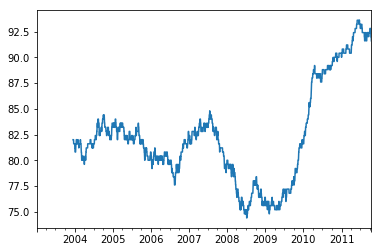

In [39]:
from scipy.stats import percentileofscore
score_at_2percent = lambda x: percentileofscore(x, 0.02)
result = returns.AAPL.rolling(window=250,center=False).apply(func=score_at_2percent)
result.plot()